## Manometer Models and Dynamics

This notebook demonstrates the modeling and interactive simulation of a u-tube manometer. This device demonstrates a variety of behaviors that can be exhibited by a linear second order system. An interesting feature of the problem is the passive design for acceptable measurement device.

#### Contents

* [Model 1. Steady State Response to a Pressure Differential](#model1)
* [Model 2. Dynamic Response with Negligible Viscosity](#model2)
* [Model 3. Dynamic Response with Viscous Dissipation](#model3)
* [Model 4. Second Order System in Standard Form](#model4)
* [Model 5. Dynamic Response to Sinusoidal Input](#model5)
* [Model 6. State Space Representation](#model6)

#### Learning Goals

* Develop linear differential equations models for mechanical systems from momentum/force balances. 
* Describe role of position and velocity as state variables in a dynamic model.
* Describe undamped, underdamped, overdamped, and critically damped responses.
* Represent a second order system in standard form with natural frequency and damping factor.
* Describe second order response to sinusoidal input, and resonance.
* Construct a state space representation of a second order linear differential equation.

#### Initializations

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy import linalg as la
from ipywidgets import interact
from control.matlab import *

# scales for all subsequent plots
tmax = 20
ymin = -0.25
ymax = +0.25
axis = [0.0,tmax,ymin,ymax]
t = np.linspace(0.0,tmax,1000)

# physical parameters
g = 9.8          # m/s
rho = 1000.0     # density of water kg/m^3
nu = 1.0e-6      # kinematic viscosity of water m/s^2

<a id="model1"></a>
## Model 1. Steady State Response to a Pressure Differential

For this first model we will that the ends of the u-tube are exposed to a pressure differential $\Delta P$.  How does the level in the tubes change?

The u-tube manometer of cross-sectional area $A$, filled with a liquid of density $\rho$, the total length of the liquid column $L$. When the ends are open and exposed to the same environmental pressure $P$ the liquid levels in the two the legs of the device will reach the same level. We'll measure the levels in the tubes as a deviation $y$ from this equilibrium position.

At steady state the difference in the levels of the tubes will be $2y$. The static pressure difference 

$$\Delta P = 2\rho g y$$

or 

$$y = \frac{\Delta P}{2\rho g}$$

This is simple statics. Notice that neither the cross-sectional area or the length of the liquid column matter.  This is the rationale behind the common water level.

<a href="https://commons.wikimedia.org/wiki/File:Schlauchwaage_Schematik.svg#/media/File:Schlauchwaage_Schematik.svg"><img src="https://upload.wikimedia.org/wikipedia/commons/0/08/Schlauchwaage_Schematik.svg" alt="Schlauchwaage Schematik.svg" width="250"></a><br>By <a href="https://de.wikipedia.org/wiki/User:Bd" class="extiw" title="de:User:Bd">Bd</a> at the <a href="https://de.wikipedia.org/wiki/" class="extiw" title="de:">German language Wikipedia</a>, <a href="http://creativecommons.org/licenses/by-sa/3.0/" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>, <a href="https://commons.wikimedia.org/w/index.php?curid=46342405">Link</a>


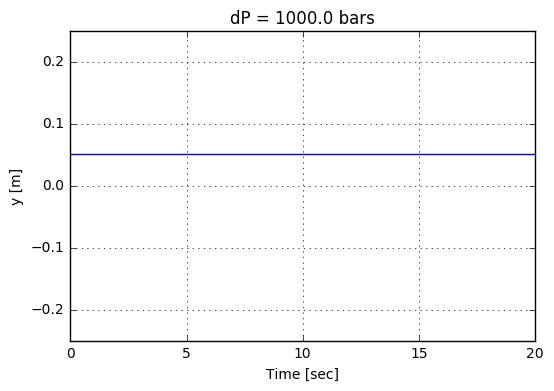

In [2]:
def model1(deltaP = 1000.0):
    y = deltaP/(2*rho*g)
    plt.axis(axis)
    plt.plot(plt.xlim(),[y,y])
    plt.grid()
    plt.xlabel('Time [sec]')
    plt.ylabel('y [m]')
    plt.title('dP = {0:5.1f} bars'.format(deltaP))

interact(model1,deltaP=(0.0,2000.0,20.0));

<a id="model2"></a>
## Model 2. Dynamic Response with Negligible Viscosity

The second model for the manometer includes the dynamics associated with moving a mass $m$ of liquid held within the manometer. The net force acting on the liquid is the difference between the force due to the applied pressure differential, $A\Delta P$, and the gravitational force due to the difference between the liquid heights in the two arms of the manometer, $2 A \rho g$, where $A$ is the cross-sectional area. From Newton's law

$$m \frac{d^2y}{dt^2} = A \Delta P - 2 A \rho g y$$

The mass of liquid is $m = \rho A L$ where $L$ is the total length of the liquid column.  After canceling a common factor $A$, the result is an inhomogeneous linear second order differential equation

$$ \frac{d^2y}{dt^2} + \frac{2 g}{L} y = \frac{1}{\rho L} \Delta P$$

At steady state this model reduces to the static case outlined in model 1 above. The dynamic case corresponds to an undamped harmonic oscillator with an angular frequency

$$\omega = \sqrt{\frac{2 g}{L}}$$

For numerical solution using the scipy libraries, it is necessary to convert the second order differential equation to a system of first order differential equations. 

$$\begin{align*}
\frac{dy}{dt} & = v \\
\frac{dv}{dt} & = -\frac{2g}{L} y + \frac{1}{\rho L} \Delta P 
\end{align*}$$

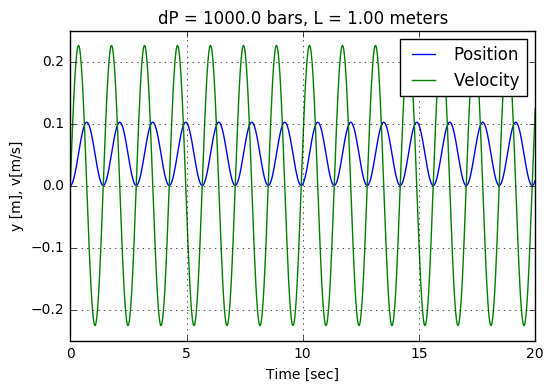

In [3]:
def model2(deltaP=1000, L = 1.0):

    def deriv(X,t):
        x,v = X
        xdot = v
        vdot = -(2*g/L)*x + deltaP/rho/L
        return [xdot,vdot]

    IC = [0,0]
    sol = odeint(deriv,IC,t)
    plt.axis(axis)
    plt.plot(t,sol)
    plt.grid()
    plt.xlabel('Time [sec]')
    plt.ylabel('y [m], v[m/s]')
    plt.title('dP = {0:5.1f} bars, L = {1:4.2f} meters'.format(deltaP,L))
    plt.legend(['Position','Velocity'])
    
interact(model2, deltaP = (0,2000,20), L = (0.2,5,0.1));

<a id="model3"></a>
## Model 3. Dynamic Response with Viscous Dissipation

This third model for manometer incorporates the energy loss due to viscous dissipation in fluid motion. 

The pressure drop due to the laminar flow of incompressible Newtonian fluid in a long pipe with circular cross-section is given by the Hagen-Poiseuille equation

$$\Delta P_{drag} = \frac{32 \mu L v}{d^2}$$

where $\mu$ is dynamic viscosity and $d$ is pipe diameter. Recasting in terms of cross-sectional area

$$A = \frac{\pi d^2}{4}$$

gives

$$\Delta P_{drag} = \frac{8 \pi \mu L v}{A}$$

Let's assume this is a good model for the viscous dissipation that takes place inside the u-tube manometer. Doing a balance of forces acting on the fluid column

$$\rho AL\frac{d^2y}{dt^2} + 8\frac{\pi \mu L}{A}v + 2 A \rho g y = A \Delta P$$

Substituting for velocity $v = \frac{dy}{dt}$

$$\frac{d^2y}{dt^2} + 8 \frac{\pi \mu }{\rho A^2}\frac{dy}{dt} + 2\frac{g}{L} y = \frac{1}{\rho L} \Delta P$$

Finally, the substitution $A = \pi d^2/4$ makes the dependence on pipe diameter more clear.

$$\frac{d^2y}{dt^2} + 128 \frac{\nu }{\pi d^4}\frac{dy}{dt} + 2\frac{g}{L} y = \frac{1}{\rho L} \Delta P$$

where the kinematic viscosity $\nu = \frac{\mu}{\rho}$ has been introduced.

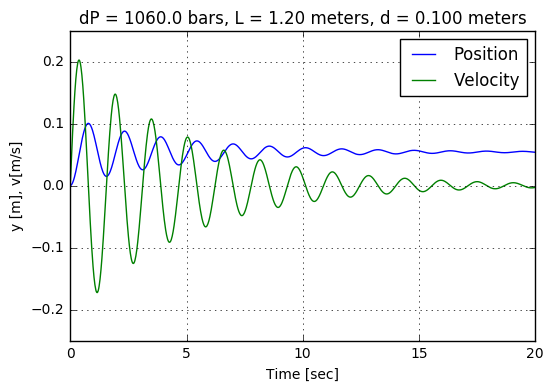

In [4]:
def model3(dP = 1000.0, L = 1.0, d = 0.10):

    def deriv(X,t):
        x,v = X
        xdot = v
        vdot = -(2*g/L)*x - (128*nu/np.pi/d**4)*v + dP/rho/L
        return [xdot,vdot]

    IC = [0,0]
    sol = odeint(deriv,IC,t)
    plt.axis(axis)
    plt.plot(t,sol)
    plt.grid()
    plt.xlabel('Time [sec]')
    plt.ylabel('y [m], v[m/s]')
    plt.title('dP = {0:5.1f} bars, L = {1:4.2f} meters, d = {2:5.3f} meters'.format(dP,L,d))
    plt.legend(['Position','Velocity'])

interact(model3, dP=(0,2000,20), L = (0.2,5,0.1), d=(0.01,0.20,0.002));

<a id="model4"></a>
## Model 4. Second Order System in Standard Form

Standard form of a damped second order system is

$$\tau^2\frac{d^2y}{dt^2} + 2\zeta\tau\frac{dy}{dt} + y = u(t)$$

Examples include buildings, car suspensions, other structures. Comparing 

$$\frac{d^2y}{dt^2} + 128 \frac{\nu }{\pi d^4}\frac{dy}{dt} + 2\frac{g}{L} y = \frac{1}{\rho L} \Delta P$$

$$\frac{gL}{2}\frac{d^2y}{dt^2} + 64 \frac{\nu L}{\pi g d^4}\frac{dy}{dt} + y = \frac{1}{2\rho g} \Delta P$$

$$\begin{align*}
\omega^2 & = 2\frac{g}{L} \\
2\zeta\omega & = 128 \frac{\nu }{\pi d^4} 
\end{align*}$$

#### Undamped ($\zeta = 0$)

#### Underdamped ($\zeta < 1$)

#### Critically damped ($\zeta = 1$)

#### Overdamped ($\zeta > 1$)

<a id="model5"></a>
## Model 5. Dynamic Response to Sinusoidal Input

$$\frac{d^2y}{dt^2} + 128 \frac{\nu }{\pi d^4}\frac{dy}{dt} + 2\frac{g}{L} y = \frac{1}{\rho L} \Delta P \sin(2\pi f t)$$

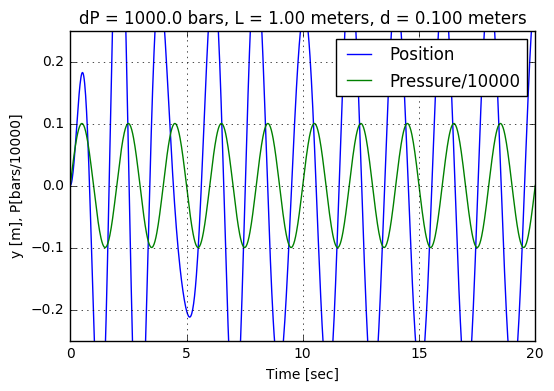

In [171]:
def model4(dP=1000.0, L=1.0, d=0.10, freq=0.5):

    def deriv(X,t):
        x,v = X
        xdot = v
        vdot = -(2*g/L)*x - (128*nu/np.pi/d**4)*v + dP*np.sin(2.0*np.pi*freq*t)/rho/L
        return [xdot,vdot]

    IC = [0,0]
    sol = odeint(deriv,IC,t)
    plt.axis(axis)
    plt.plot(t,sol[:,1])
    plt.plot(t,dP*np.sin(2.0*np.pi*freq*t)/10000)
    plt.grid()
    plt.xlabel('Time [sec]')
    plt.ylabel('y [m], P[bars/10000]')
    plt.title('dP = {0:5.1f} bars, L = {1:4.2f} meters, d = {2:5.3f} meters'.format(dP,L,d))
    plt.legend(['Position','Pressure/10000'])

interact(model4, dP=(0,2000,20), L = (0.2,5,0.1), d=(0.01,0.20,0.002), freq=(0,4,0.01));

<a id="model6"></a>
## Model 6. State Space Representation

State space models are widely used in textbooks, software, and the research literature to represent linear systems. It's a generic model that represents a system with inputs and outputs. Here's how to recast out manometer model is time-varying pressure as a state model where the liquid level is the measured output.

Start with the model written as a differential equation

$$\frac{d^2y}{dt^2} + 128\frac{\nu }{\pi d^4}\frac{dy}{dt} + 2\frac{g}{L} y = \frac{1}{\rho L} \Delta P$$

Assemble the dependent variables in a vector, and rewrite using matrix/vector operations.

$$\begin{align*}
\frac{d}{dt}
\left[\begin{array}{c}y \\ v\end{array}\right]
& =
\left[\begin{array}{cc}0 & 1 \\ - \frac{2g}{L} & -\frac{128\nu }{\pi d^4} \end{array}\right]
\left[\begin{array}{c}y \\ v\end{array}\right]
+
\left[\begin{array}{c}0 \\ \frac{1}{\rho L}\end{array}\right]
\left[\Delta P\right] \\
\left[y\right]
& =
\left[\begin{array}{c} 1 & 0\end{array}\right]
\left[\begin{array}{c}y \\ v\end{array}\right]
+
\left[0\right]
\left[\Delta P\right]
\end{align*}
$$

Use standard symbols to label the vectors and matrices.

$$\begin{align*}
\frac{d}{dt}
\underbrace{\left[\begin{array}{c}y \\ v\end{array}\right]}_{x}
& =
\underbrace{\left[\begin{array}{cc}0 & 1 \\ - \frac{2g}{L} & -\frac{128\nu }{\pi d^4} \end{array}\right]}_{A}
\underbrace{\left[\begin{array}{c}y \\ v\end{array}\right]}_{x}
+
\underbrace{\left[\begin{array}{c}0 \\ \frac{1}{\rho L}\end{array}\right]}_{B}
\underbrace{\left[\Delta P\right]}_{u} \\
\underbrace{\left[y\right]}_{y} 
& =
\underbrace{\left[\begin{array}{c} 1 & 0\end{array}\right]}_{C}
\underbrace{\left[\begin{array}{c}y \\ v\end{array}\right]}_{x}
+
\underbrace{\left[0\right]}_{D}
\underbrace{\left[\Delta P\right]}_{u}
\end{align*}
$$

The result is a model of a linear system in a standard state space representation. 

$$\begin{align*}
\frac{dx}{dt} & = Ax + Bu \\
y & = Cx + Du
\end{align*}$$



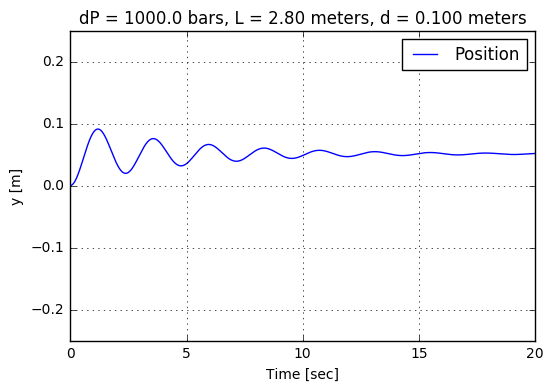

In [194]:
def model6(dP=1000, L=1.0, d=0.10):

    A = [[0,1],[-2*g/L, -128*nu/(np.pi*d**4)]]
    B = [[0],[1/rho/L]]
    C = [[1,0]]
    D = [[0]]
    
    sys = ss(A,B,C,D)
    y,tout = step(sys,t);

    plt.axis(axis)
    plt.plot(t,dP*y)
    plt.grid()
    plt.xlabel('Time [sec]')
    plt.ylabel('y [m]')
    plt.title('dP = {0:5.1f} bars, L = {1:4.2f} meters, d = {2:5.3f} meters'.format(dP,L,d))
    plt.legend(['Position'])
    
interact(model6, dP=(0,2000,20), L = (0.2,5,0.1), d=(0.01,0.20,0.002));

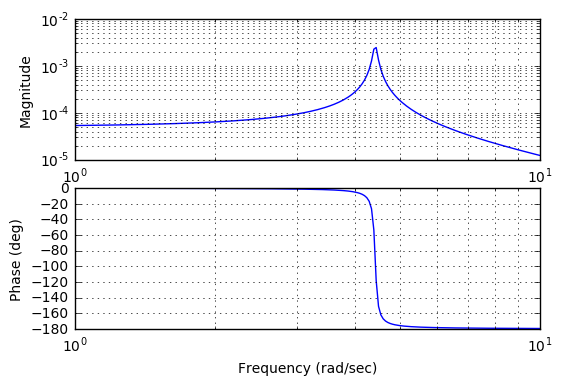

In [197]:
w = np.logspace(0,1,200)

def model6(L=1.0, d=0.10):

    A = [[0,1],[-2*g/L, -128*nu/(np.pi*d**4)]]
    B = [[0],[1/rho/L]]
    C = [[1,0]]
    D = [[0]]

    mano = ss(A,B,C,D)
    bode(mano,w);
    
interact(model6, L = (0.2,5,0.1), d=(0.01,0.20,0.002));

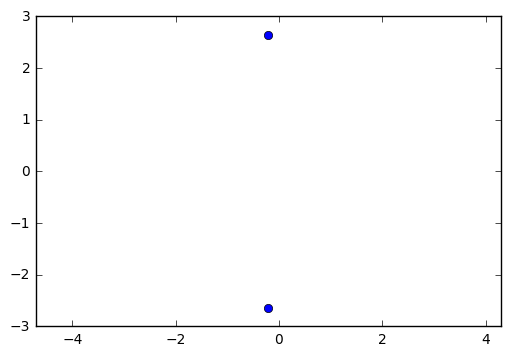

In [204]:
w = np.logspace(0,1,200)

def model6(L=1.0, d=0.10):

    A = [[0,1],[-2*g/L, -128*nu/(np.pi*d**4)]]
    B = [[0],[1/rho/L]]
    C = [[1,0]]
    D = [[0]]

    e_vals,e_vecs = la.eig(A)
    
    plt.axis([-5,5,-5,5])
    plt.axis('equal')
    plt.plot(e_vals.real,e_vals.imag,'o')
    
    
    
interact(model6, L = (0.2,5,0.1), d=(0.01,0.20,0.002));